# FashionMnist图像分类实验

本实验主要介绍使用MindSpore开发前馈神经网络，并使用Fashion-MNIST数据集训练和测试模型。

## 1、实验目的

- 掌握如何使用MindSpore进行简单前馈神经网络的开发。
- 了解如何使用MindSpore进行简单图片分类任务的训练。
- 了解如何使用MindSpore进行简单图片分类任务的测试和预测。

## 2、前馈神经网络原理介绍

前馈神经网络（feedforward neural network，FNN），简称前馈网络，是人工神经网络的一种。前馈神经网络采用一种单向多层结构。其中每一层包含若干个神经元。在此种神经网络中，各神经元可以接收前一层神经元的信号，并产生输出到下一层。第0层叫输入层，最后一层叫输出层，其他中间层叫做隐含层（或隐藏层、隐层）。隐层可以是一层。也可以是多层。

整个网络中无反馈，信号从输入层向输出层单向传播，可用一个有向无环图表示。



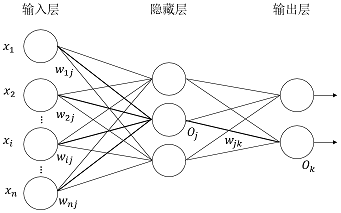

## 3、实验环境

- MindSpore 2.0（MindSpore版本会定期更新，本指导也会定期刷新，与版本配套）；
- 本案例支持win_x86和Linux系统，CPU/GPU/Ascend均可运行。
- 如果在本地运行此实验，请参考《MindSpore环境搭建实验手册》在本地安装MindSpore。

## 4、数据处理

### 4.1数据集准备

Fashion-MNIST是一个替代MNIST手写数字集的图像数据集。 它是由Zalando（一家德国的时尚科技公司）旗下的研究部门提供。其涵盖了来自10种类别的共7万个不同商品的正面图片。Fashion-MNIST的大小、格式和训练集/测试集划分与原始的MNIST完全一致。60000/10000的训练测试数据划分，28x28x1的灰度图片。

这里介绍一下经典的MNIST（手写字母）数据集。经典的MNIST数据集包含了大量的手写数字。十几年来，来自机器学习、机器视觉、人工智能、深度学习领域的研究员们把这个数据集作为衡量算法的基准之一。实际上，MNIST数据集已经成为算法作者的必测的数据集之一，但是MNIST数据集太简单了。很多深度学习算法在测试集上的准确率已经达到99.6%。

从[Fashion-MNIST GitHub仓库](https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com:443/deep-learning/Fashion-MNIST.zip)下载如下4个文件到本地并解压：

```
train-images-idx3-ubyte     training set images（47,042,560 bytes）   
train-labels-idx1-ubyte     training set labels（61,440 bytes）  
t10k-images-idx3-ubyte      test set images (7,843,840 bytes)  
t10k-labels-idx1-ubyte      test set labels (12,288 bytes) 
```

In [1]:
from download import download

# 下载MNIST数据集
url = "https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com:443/deep-learning/Fashion-MNIST.zip"
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 30.3M/30.3M [00:25<00:00, 1.18MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


## 4.2数据加载

#### 导入MindSpore模块和辅助模块

用到的框架主要包括：

- mindspore，用于神经网络的搭建 
- numpy，用于处理一些数据 
- matplotlib，用于画图、图像展示
- struct，用于处理二进制文件

In [1]:
import os
import struct
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import numpy as np

import mindspore
import mindspore.dataset as ds
import mindspore.nn as nn
from mindspore.train import Model, Accuracy
from mindspore.train import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore import Tensor

mindspore.set_context(mode=mindspore.GRAPH_MODE, device_target='CPU')

#### 变量定义

In [2]:
cfg = edict({
    'train_size': 60000,    # 训练集大小
    'test_size': 10000,     # 测试集大小
    'channel': 1,           # 图片通道数
    'image_height': 28,     # 图片高度
    'image_width': 28,      # 图片宽度
    'batch_size': 60,
    'num_classes': 10,      # 分类类别
    'lr': 0.001,            # 学习率
    'epoch_size': 10,       # 训练次数
    #此处应该改为自己数据集存储的路径，分别用train和test两个文件夹存储训练数据集和测试数据集
    'data_dir_train': os.path.join('./Fashion-MNIST/train/'),
    'data_dir_test': os.path.join('./Fashion-MNIST/test/'),
    'save_checkpoint_steps': 1,  # 多少步保存一次模型
    'keep_checkpoint_max': 3,    # 最多保存多少个模型
    'output_directory': './model_fashion',         # 保存模型路径
    'output_prefix': "checkpoint_fashion_forward"  # 保存模型文件名字
})

#### 读取并处理数据

数据经过数据读取函数read_image后，数据的格式如下：
- 训练的图片的二进制格式:
```
    
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
```
- 标签的格式：

```
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.
```

In [3]:
def read_image(file_name):
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()    # 读取到缓冲区中
    head = struct.unpack_from('>IIII', file_content, 0)  # 取前4个整数，返回一个元组
    offset = struct.calcsize('>IIII')
    imgNum = head[1]   # 图片数
    width = head[2]    # 宽度
    height = head[3]   # 高度
    bits = imgNum * width * height      # data一共有60000*28*28个像素值
    bitsString = '>' + str(bits) + 'B'  # fmt格式：'>47040000B'
    imgs = struct.unpack_from(bitsString, file_content, offset)    # 取data数据，返回一个元组
    imgs_array = np.array(imgs).reshape((imgNum, width * height))  # 最后将读取的数据reshape成 【图片数，图片像素】二维数组
    return imgs_array


def read_label(file_name):
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()    # 读取到缓冲区中
    head = struct.unpack_from('>II', file_content, 0)  # 取前2个整数，返回一个元组
    offset = struct.calcsize('>II')
    labelNum = head[1]  # label数
    bitsString = '>' + str(labelNum) + 'B'  # fmt格式：'>47040000B'
    label = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    return np.array(label)


def get_data():
    # 文件获取
    train_image = os.path.join(cfg.data_dir_train, 'train-images-idx3-ubyte')
    test_image = os.path.join(cfg.data_dir_test, "t10k-images-idx3-ubyte")
    train_label = os.path.join(cfg.data_dir_train, "train-labels-idx1-ubyte")
    test_label = os.path.join(cfg.data_dir_test, "t10k-labels-idx1-ubyte")
    # 读取数据
    train_x = read_image(train_image)
    test_x = read_image(test_image)
    train_y = read_label(train_label)
    test_y = read_label(test_label)
    return train_x, train_y, test_x, test_y

###### 数据预处理和处理结果图片展示

训练数据集样本数： 60000
测试数据集样本数： 10000
通道数/图像长/宽： (1, 28, 28)
一张图像的标签样式： 9


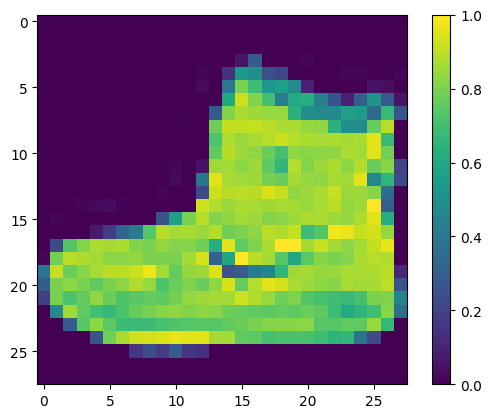

In [4]:
train_x, train_y, test_x, test_y = get_data()
# 第一维度是batchsize的数据,第二维度是图像的channel数，第三，第四维度是高和宽
train_x = train_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
test_x = test_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
# 归一化至0和1之间
train_x = train_x / 255.0
test_x = test_x / 255.0
# 修改数据格式
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_y = train_y.astype('int32')
test_y = test_y.astype('int32')
print('训练数据集样本数：', train_x.shape[0])
print('测试数据集样本数：', test_y.shape[0])
print('通道数/图像长/宽：', train_x.shape[1:])
# 一共10类，用0-9的数字表达类别。
print('一张图像的标签样式：', train_y[0])  

plt.figure()
plt.imshow(train_x[0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()

使用MindSpore  GeneratorDataset接口将numpy.ndarray类型的数据转换为Dataset

In [5]:
# 转换数据类型为Dataset
XY_train = list(zip(train_x, train_y))
#转换数据和标签为dataset类型，并制定数据为x，标签为y
ds_train = ds.GeneratorDataset(XY_train, ['x', 'y'])
ds_train = ds_train.shuffle(buffer_size=cfg.train_size).batch(cfg.batch_size, drop_remainder=True)
XY_test = list(zip(test_x, test_y))
ds_test = ds.GeneratorDataset(XY_test, ['x', 'y'])
ds_test = ds_test.shuffle(buffer_size=cfg.test_size).batch(cfg.batch_size, drop_remainder=True)

## 5、构建前馈神经网络

前馈神经网络是一种最简单的神经网络，各神经元分层排列（其中每一层包含若干个神经元）。每个神经元只与前一层的神经元相连，接收前一层的输出，并输出给下一层，各层间没有反馈。是目前应用最广泛、发展最迅速的人工神经网络之一。第0层叫输入层，最后一层叫输出层，其他中间层叫做隐含层（或隐藏层、隐层）。隐层可以是一层，也可以是多层，是由全连接层堆叠而成。


In [6]:
# 定义前馈神经网络
class Forward_fashion(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(Forward_fashion, self).__init__()
        self.num_class = num_class
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(cfg.channel * cfg.image_height * cfg.image_width, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## 6、模型训练

使用Fashion-MNIST数据集对上述定义的前馈神经网络模型进行训练。训练策略如下表所示，可以调整训练策略并查看训练效果。

batch size|number of epochs	| learning rate	|input shape|optimizer
:--:|:--:|:--:|:--:|:--:
60|20|0.001|(1，28，28)|Adam

In [7]:
# 构建网络
network = Forward_fashion(cfg.num_classes)
# 定义模型的损失函数，优化器
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
net_opt = nn.Adam(network.trainable_params(), cfg.lr)
# 训练模型
model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={"acc"})

# 定义用于训练的train_loop函数。
def train_loop(model, dataset, loss_fn, optimizer):
    # 定义正向计算函数
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss

    # 定义微分函数，使用mindspore.value_and_grad获得微分函数grad_fn,输出loss和梯度。
    # 由于是对模型参数求导,grad_position 配置为None，传入可训练参数。
    grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters)

    # 定义 one-step training函数
    def train_step(data, label):
        loss, grads = grad_fn(data, label)
        optimizer(grads)
        return loss

    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)

        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

# 定义用于测试的test_loop函数。
def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = cfg.epoch_size
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(network, ds_train, net_loss, net_opt)
    test_loop(network, ds_test, net_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304416  [  0/1000]
loss: 0.777157  [100/1000]
loss: 0.639328  [200/1000]
loss: 0.432101  [300/1000]
loss: 0.655552  [400/1000]
loss: 0.573839  [500/1000]
loss: 0.617169  [600/1000]
loss: 0.477679  [700/1000]
loss: 0.309522  [800/1000]
loss: 0.433140  [900/1000]
Test: 
 Accuracy: 83.3%, Avg loss: 0.466715 

Epoch 2
-------------------------------
loss: 0.321446  [  0/1000]
loss: 0.310830  [100/1000]
loss: 0.377250  [200/1000]
loss: 0.378169  [300/1000]
loss: 0.257495  [400/1000]
loss: 0.358368  [500/1000]
loss: 0.543446  [600/1000]
loss: 0.461380  [700/1000]
loss: 0.429912  [800/1000]
loss: 0.635762  [900/1000]
Test: 
 Accuracy: 84.4%, Avg loss: 0.429756 

Epoch 3
-------------------------------
loss: 0.335235  [  0/1000]
loss: 0.440504  [100/1000]
loss: 0.228520  [200/1000]
loss: 0.326491  [300/1000]
loss: 0.421762  [400/1000]
loss: 0.494814  [500/1000]
loss: 0.300194  [600/1000]
loss: 0.536214  [700/1000]
loss: 0.309543  [800/1000]
loss:

## 7、模型预测及可视化

In [8]:
# 使用测试集评估模型，打印总体准确率
metric = model.eval(ds_test)
print(metric)

{'acc': 0.8829317269076306}


In [9]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#从测试集中取出一组样本，输入模型进行预测
test_ = ds_test.create_dict_iterator().__next__()
#利用key值选出样本
test = Tensor(test_['x'], mindspore.float32)
predictions = model.predict(test)
softmax = nn.Softmax()
predictions = softmax(predictions)
predictions = predictions.asnumpy()
true_label = test_['y'].asnumpy()

for i in range(15):
    p_np = predictions[i, :]
    pre_label = np.argmax(p_np)
    print('第' + str(i) + '个sample预测结果：', class_names[pre_label], '   真实结果：', class_names[true_label[i]])

第0个sample预测结果： Pullover    真实结果： Pullover
第1个sample预测结果： Sneaker    真实结果： Sneaker
第2个sample预测结果： Sneaker    真实结果： Sandal
第3个sample预测结果： Sandal    真实结果： Sandal
第4个sample预测结果： T-shirt/top    真实结果： T-shirt/top
第5个sample预测结果： Coat    真实结果： Coat
第6个sample预测结果： Ankle boot    真实结果： Ankle boot
第7个sample预测结果： Shirt    真实结果： Shirt
第8个sample预测结果： Trouser    真实结果： Trouser
第9个sample预测结果： Ankle boot    真实结果： Ankle boot
第10个sample预测结果： Coat    真实结果： Coat
第11个sample预测结果： Coat    真实结果： Coat
第12个sample预测结果： Sandal    真实结果： Sandal
第13个sample预测结果： Sandal    真实结果： Sandal
第14个sample预测结果： Bag    真实结果： Bag


#### 对预测结果可视化

预测结果可视化，输入预测结果序列，真实标签序列，以及图片序列。目标是根据预测值对错，让其标签显示为红色或者蓝色。对：标签为蓝色；错：标签为红色。最后预测15个图像与标签，将预测的结果以柱状图形状显示蓝对红错。

In [10]:
# -------------------定义可视化函数--------------------------------
# 输入预测结果序列，真实标签序列，以及图片序列
# 目标是根据预测值对错，让其标签显示为红色或者蓝色。对：标签为蓝色；错：标签为红色
def plot_image(predicted_label, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    # 显示对应图片
    plt.imshow(img, cmap=plt.cm.binary)
    # 显示预测结果的颜色，如果对上了是蓝色，否则为红色
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    # 显示对应标签的格式，样式
    plt.xlabel('{},({})'.format(class_names[predicted_label],
                                    class_names[true_label]), color=color)

In [11]:
# 将预测的结果以柱状图形状显示蓝对红错
def plot_value_array(predicted_label, true_label,predicted_array):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    this_plot = plt.bar(range(10), predicted_array, color='#777777')
    plt.ylim([0, 1])
    this_plot[predicted_label].set_color('red')
    this_plot[true_label].set_color('blue')

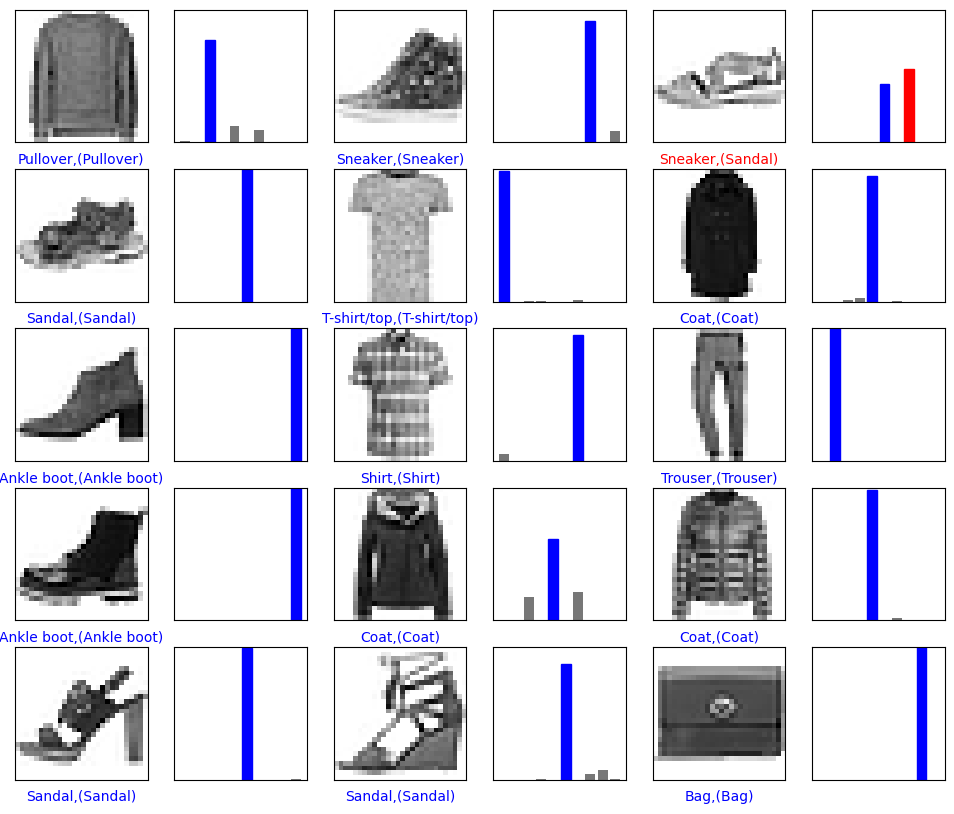

In [12]:
# 预测15个图像与标签，并展现出来
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    pred_np_ = predictions[i, :]
    predicted_label = np.argmax(pred_np_)
    image_single = test_['x'][i, 0, ...].asnumpy()
    plot_image(predicted_label, true_label[i], image_single)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(predicted_label, true_label[i], pred_np_)
plt.show()